# Assignment One (CS 7180)

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 0. Package Versions

In [2]:
print("Python version: {}\n".format(sys.version))
print("Numpy version: {}".format(np.__version__))
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}\n".format(torchvision.__version__))

Python version: 3.6.5 |Anaconda custom (64-bit)| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]

Numpy version: 1.14.5
Torch version: 0.4.1
Torchvision version: 0.2.1



In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla K80


### 1. Load Data

In [4]:
# 1. Load MNIST training and test data from torchvision.datasets.MNIST.
# 2. Please use data.DataLoader and print out dataset size, sample size, batch size.
#******************************#

print("Transformation on MNIST: \n\n{}\n".format(transforms.ToTensor().__doc__))

transform = transforms.Compose(
    [transforms.ToTensor()]) 

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, 
                                transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, 
                               transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#******************************#

Transformation on MNIST: 

Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.

    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    



### 2. Define Hyper-parameters

In [5]:
# Define hyper-parameters
#******************************#

num_classes = 10

hyperparams = {
    "batch_size"       : 32,
    "test_batch_size"  : 1000,
    "epochs"           : 10,
    "learning_rate"    : 0.001,
    "momentum"         : 0.9,
    "random_seed"      : 42,
    
    # Params related to reporting
    
    "log_interval"     : 10000,
}

#******************************#

### 3. Define a Convolutional Neural Network

In [6]:
# Pytorch MNIST example reference:
#   https://github.com/pytorch/examples/blob/master/mnist/main.py

class ConvNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.0):
        super(ConvNet, self).__init__()
        # 3.1 Initialization
        #******************************#
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        #******************************#
    def forward(self, x):
        # 3.2 Define Neural Network
        #******************************#
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.fc2(out)
        #******************************#
        return out
    
    def count_params(self):
        pytorch_total_params = sum(p.numel() for p in super(ConvNet, self).parameters())
        return pytorch_total_params

# Note: what is the difference between 'same' and 'valid' padding? 
# Take a look at the outputs to understand the difference.

### 4. Training the Model

In [7]:
# Training and testing functions

def performance(result_metrics: tuple, epoch: int, pmeta: list, set_type: str, print_result=True):
    meta = {
        "set_type": None,
        "epoch": None,
        "n_correct": None,
        "loss": None,
        "n_instances": None,
    }
    loss, n_correct, n_instances = result_metrics
    
    meta["set_type"] = set_type
    meta["epoch"] = epoch
    meta["n_correct"] = n_correct
    meta["loss"] = loss
    meta["n_instances"] = n_instances
    
    pmeta.append(meta)
    
    # Print performance update
    if print_result:
        print('{} => Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
            set_type.capitalize(), loss, n_correct, n_instances, 100.0 * n_correct / n_instances))
    return pmeta

def train(hyperparams, model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    log_interval = hyperparams["log_interval"]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        # store each loss and accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    instance_count = len(train_loader.dataset)
    train_loss /= instance_count
    
    return (train_loss, correct, instance_count)
            
def test(hyperparams, model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.cuda()
            target = target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    instance_count = len(test_loader.dataset)
    return (test_loss, correct, instance_count)

def train_model(model, optimizer, criterion, hyperparams, train_loader, test_loader):
    """ Train generic model """
    
    pmeta = []
    for epoch in range(1, hyperparams["epochs"] + 1):
        
        print("Training/Validation Epoch {}".format(epoch))
        
        train_metrics = train(hyperparams, model, train_loader, 
                              optimizer, criterion, epoch)
        pmeta = performance(result_metrics=train_metrics, 
                        epoch=epoch, set_type="train", pmeta=pmeta)
        
        test_metrics = test(hyperparams, model, criterion, 
                            device, test_loader)
        pmeta = performance(result_metrics=test_metrics,
                           epoch=epoch, set_type="dev", pmeta=pmeta)
        print("\n")
    
    return pmeta

In [8]:
# 4.1 Define criterion and optimizer
#************************************#

model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"],
                            momentum=hyperparams["momentum"])

#************************************#


# 4.2 Train the model
# 4.3 Please store and print training and validation loss&accuracy after each epoch
#********************************************#

training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                              train_loader, test_loader)

#*******************************************#

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321619
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.002574
Train => Average loss: 0.0438, Accuracy: 56761/60000 (94.60%)
Dev => Average loss: 0.0563, Accuracy: 9833/10000 (98.33%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.009301
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000878
Train => Average loss: 0.0140, Accuracy: 58975/60000 (98.29%)
Dev => Average loss: 0.0408, Accuracy: 9870/10000 (98.70%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.002083
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.002766
Train => Average loss: 0.0102, Accuracy: 59207/60000 (98.68%)
Dev => Average loss: 0.0341, Accuracy: 9888/10000 (98.88%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.008655
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.131791
Train => Average loss: 0.0080, Accuracy: 59398/60000 (99.00%)
Dev => Average loss: 0.0358, Accuracy: 9887/10000 (98.87%)


Training/Validat

### 5. Model Evaluation

Total number of parameters in the model: 431080, less than max params: True


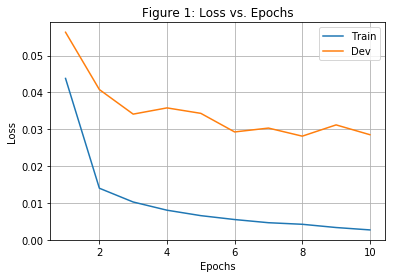

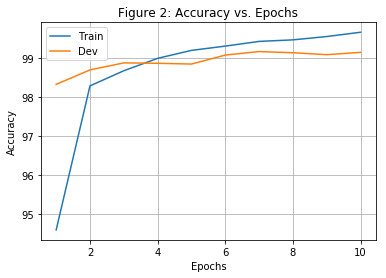

In [9]:
# 5.1 Print number of parameters in the model
#************************************#
MAX_PARAMS = 1000000
print("Total number of parameters in the model: {}, less than max params: {}".\
      format(model.count_params(), model.count_params() < MAX_PARAMS))
#************************************#

def make_plt(x,y, z, x_lbl, y_lbl, title):
    fig, ax = plt.subplots()
    train_plt, = ax.plot(x, y, label="Train")
    dev_plt, = ax.plot(x, z, label="Dev")
    ax.set(xlabel=x_lbl, ylabel=y_lbl,
           title=title)
    plt.legend(handles=[train_plt, dev_plt])
    ax.grid()
    return fig, ax


# 5.2 Summarize history for loss and make loss vs.epoch plot
#************************************#

def mat_loss_epoch(training_metrics: list):
    epochs = []
    train_loss_values = []
    dev_loss_values = []
    
    for item in training_metrics:
        
        if item["set_type"] == "train":
            train_loss_values.append(item["loss"])
            epochs.append(item["epoch"])
        
        elif item["set_type"] == "dev":
            dev_loss_values.append(item["loss"])
        
        else:
            raise("Wrong set type: {}".format(item.get("set_type")))

    m = np.array([epochs, train_loss_values, dev_loss_values])
    return m


m_loss = mat_loss_epoch(training_metrics)
make_plt(m_loss[0,:], m_loss[1,:], m_loss[2,:], 
         "Epochs", "Loss", "Figure 1: Loss vs. Epochs")


#************************************#

# 5.3 Summarize history for accuracy and make accuracy vs.epoch plot
#************************************#

def mat_accuracy_epoch(training_metrics: list):
    epochs = []
    train_accuracy = []
    dev_accuracy = []
    
    for item in training_metrics:
        
        if item["set_type"] == "train":
            train_accuracy.append(
                100.0 * item["n_correct"] / item["n_instances"]
            )
            epochs.append(item["epoch"])
        
        elif item["set_type"] == "dev":
            dev_accuracy.append(
                100.0 * item["n_correct"] / item["n_instances"]
            )
        
        else:
            raise("Wrong set type: {}".format(item.get("set_type")))
            
    m = np.array([epochs, train_accuracy, dev_accuracy])
    return m

m_accu = mat_accuracy_epoch(training_metrics)
make_plt(m_accu[0,:], m_accu[1,:], m_accu[2,:], 
         "Epochs", "Accuracy", "Figure 2: Accuracy vs. Epochs")

#************************************#

plt.show()

### 5. Varying dropout probabilities

In [10]:
# Set the probabilities of your dropout layers to 10 equally-spaced valuesp∈[0,1], 
# train for 1 epoch and report the final model accuracies for each.
#************************************#


hyperparams["epochs"] = 1
for i in range(11):
    
    p = round(0.1 * i,2)
    print("Dropout probability: {}".format(round(p,2)))
    model = ConvNet(num_classes, p).to(device)
    training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

#************************************#

Dropout probability: 0.0
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.276362
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.296694
Train => Average loss: 0.5759, Accuracy: 7958/60000 (13.26%)
Dev => Average loss: 2.3030, Accuracy: 1300/10000 (13.00%)


Dropout probability: 0.1
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.396435
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.302342
Train => Average loss: 0.5746, Accuracy: 6829/60000 (11.38%)
Dev => Average loss: 2.2989, Accuracy: 976/10000 (9.76%)


Dropout probability: 0.2
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334013
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.292241
Train => Average loss: 0.5760, Accuracy: 6976/60000 (11.63%)
Dev => Average loss: 2.3030, Accuracy: 1110/10000 (11.10%)


Dropout probability: 0.3
Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.328889
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.284512
Train => Average loss: 0.5757, Accuracy: 638

In [11]:
# Dropout p=0.25 looks the most promising

model = ConvNet(num_classes, dropout=0.25).to(device)
hyperparams["epochs"] = 10
training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.367359
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.279836
Train => Average loss: 0.5756, Accuracy: 6034/60000 (10.06%)
Dev => Average loss: 2.3026, Accuracy: 933/10000 (9.33%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.316309
Train Epoch: 2 [40000/60000 (67%)]	Loss: 2.310788
Train => Average loss: 0.5757, Accuracy: 5979/60000 (9.96%)
Dev => Average loss: 2.3026, Accuracy: 933/10000 (9.33%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.249895
Train Epoch: 3 [40000/60000 (67%)]	Loss: 2.267923
Train => Average loss: 0.5757, Accuracy: 6024/60000 (10.04%)
Dev => Average loss: 2.3026, Accuracy: 933/10000 (9.33%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.315483
Train Epoch: 4 [40000/60000 (67%)]	Loss: 2.311151
Train => Average loss: 0.5756, Accuracy: 6001/60000 (10.00%)
Dev => Average loss: 2.3026, Accuracy: 933/10000 (9.33%)


Training/Validation Epoch 5
T

## L2 Regularization

Dropout really didn't work well with my model,
let's try L2 Regularization because the training
set is definitely overfitting.

In [12]:
hyperparams["weight_decay"] = 1e-3
hyperparams["epochs"] = 10

In [13]:
model = ConvNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparams["learning_rate"],
                            momentum=hyperparams["momentum"],
                           weight_decay=hyperparams["weight_decay"])


training_metrics = train_model(model, optimizer, criterion, hyperparams, 
                                   train_loader, test_loader)

Training/Validation Epoch 1
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.276527
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.001451
Train => Average loss: 0.0478, Accuracy: 56466/60000 (94.11%)
Dev => Average loss: 0.0625, Accuracy: 9791/10000 (97.91%)


Training/Validation Epoch 2
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.020019
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.000611
Train => Average loss: 0.0152, Accuracy: 58890/60000 (98.15%)
Dev => Average loss: 0.0398, Accuracy: 9867/10000 (98.67%)


Training/Validation Epoch 3
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.056950
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.002677
Train => Average loss: 0.0117, Accuracy: 59144/60000 (98.57%)
Dev => Average loss: 0.0401, Accuracy: 9883/10000 (98.83%)


Training/Validation Epoch 4
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.005851
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.001404
Train => Average loss: 0.0099, Accuracy: 59282/60000 (98.80%)
Dev => Average loss: 0.0391, Accuracy: 9873/10000 (98.73%)


Training/Validat

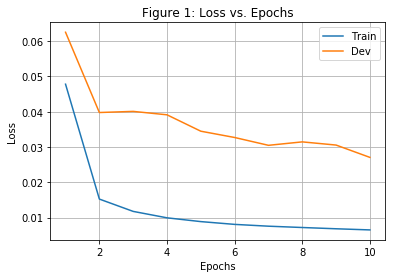

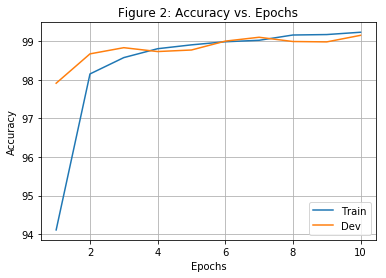

In [14]:
m_loss = mat_loss_epoch(training_metrics)
make_plt(m_loss[0,:], m_loss[1,:], m_loss[2,:], 
         "Epochs", "Loss", "Figure 1: Loss vs. Epochs")

m_accu = mat_accuracy_epoch(training_metrics)
make_plt(m_accu[0,:], m_accu[1,:], m_accu[2,:], 
         "Epochs", "Accuracy", "Figure 2: Accuracy vs. Epochs")

plt.show()